# Governer Race Analysis - Who's Gonna Win?



In [5]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 

from fnmatch import fnmatch
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import bs4
import time
#from pattern import web


# set some nicer defaults for matplotlib
from matplotlib import rcParams

#these colors come from colorbrewer2.org. Each is an RGB triplet
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = True
rcParams['axes.facecolor'] = '#eeeeee'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'none'

C:\Users\Srikanth Goli\Anaconda3\lib\site-packages\matplotlib\__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Introduction

This was the [XKCD comic](http://xkcd.com/1131/) after the 2012 Presidential election:

<img src="http://imgs.xkcd.com/comics/math.png">

The comic refers to the fact that Nate Silver's statistical model (which is based mostly on combining information from pre-election polls) correctly predicted the outcome of the 2012 presidential race in all 50 states. 

Polling data isn't a perfect predictor for the future, and some polls are more accurate than others. This means that election forecastors must consider prediction uncertainty when building models.

In this first assignment, you will perform a simple analysis of polling data about the upcoming <a href="http://en.wikipedia.org/wiki/Governor_(United_States)">Governor races</a>. The assignment has three main parts:

**First** you will build some tools to download historical polling data from the web, and parse it into a more convenient format. 

**Next** you will use these tools to aggregate and visualize several past Governor races

**Finally** you will run a bootstrap analysis to estimate the probable outcome of current Governor races, given the level of precision of historical polls.

---



## Part 1: Collect and Clean

The [Real Clear Politics](http://www.realclearpolitics.com) website archives many political polls. In addition, they combine related polls to form an "RCP average" estimate of public opinion over time. For example, the chart on [this page](http://www.realclearpolitics.com/epolls/2012/president/us/general_election_romney_vs_obama-1171.html) shows historical polling data for the Obama-Romney presidential race. The chart is an average of the polling data table below the chart.

The data used to generate plots like this are stored as XML pages, with URLs like:

http://charts.realclearpolitics.com/charts/[id].xml

Here, [id] is a unique integer, found at the end of the URL of the page that displays the graph. The id for the Obama-Romney race is 1171:

http://charts.realclearpolitics.com/charts/1171.xml

Opening this page in Google Chrome or Firefox will show you the XML content in an easy-to-read format. Notice that XML tags are nested inside each other, hierarchically (the jargony term for this is the "Document Object Model", or "DOM"). The first step of webscraping is almost always exploring the HTML/XML source in a browser, and getting a sense of this hierarchy.


---
#### Problem 1

We want to download and work with poll data like this. Like most programming tasks, we will break this into many smaller, easier pieces

Below code is for the `get_poll_xml` function, that finds and downloads an XML page discussed above


In [6]:

def get_poll_xml(id):
    xml = 'http://charts.realclearpolitics.com/charts/'+str(id)+'.xml'
    url =urllib.request.urlopen(xml).read()
    time.sleep(3)
    return url 



Here are some other functions we'll use later. `plot_colors` contains hints about parsing XML data.

In [7]:
# "r"egular "e"xpressions is kind of a mini-language to
# do pattern matching on text
import re

def _strip(s):
    """This function removes non-letter characters from a word
    
    for example _strip('Hi there!') == 'Hi there'
    """
    s = s.split(" ")[0]
    return re.sub(r'[\W_]+', '', s)

def plot_colors(xml):
    """
    Given an XML document like the link above, returns a python dictionary
    that maps a graph title to a graph color.
    
    Both the title and color are parsed from attributes of the <graph> tag:
    <graph title="the title", color="#ff0000"> -> {'the title': '#ff0000'}
    
    These colors are in "hex string" format. This page explains them:
    http://coding.smashingmagazine.com/2012/10/04/the-code-side-of-color/
    
    Example
    -------
    >>> plot_colors(get_poll_xml(1044))
    {u'Approve': u'#000000', u'Disapprove': u'#FF0000'}
    """
    soup = bs4.BeautifulSoup(xml, "xml")
    result = {}
    for l in soup.graphs.find_all('graph'):
        result[l["title"]] = l['color']
    return result

---

#### Problem 2

Even though `get_poll_xml` pulls data from the web into Python, it does so as a block of text. This still isn't very useful. We'll use some libraries such as BeautifulSoup to parse this text, and extract data into a pandas DataFrame.


In [8]:
"""
    Function
    ---------
    rcp_poll_data

    Extract poll information from an XML string, and convert to a DataFrame

    Parameters
    ----------
    xml : str
        A string, containing the XML data from a page like 
        get_poll_xml(1044)
        
    Returns
    -------
    A pandas DataFrame with the following columns:
        date: The date for each entry
        title_n: The data value for the gid=n graph (take the column name from the `title` tag)
        
    This DataFrame should be sorted by date
        
    Example
    -------
    Consider the following simple xml page:
    
    <chart>
    <series>
    <value xid="0">1/27/2009</value>
    <value xid="1">1/28/2009</value>
    </series>
    <graphs>
    <graph gid="1" color="#000000" balloon_color="#000000" title="Approve">
    <value xid="0">63.3</value>
    <value xid="1">63.3</value>
    </graph>
    <graph gid="2" color="#FF0000" balloon_color="#FF0000" title="Disapprove">
    <value xid="0">20.0</value>
    <value xid="1">20.0</value>
    </graph>
    </graphs>
    </chart>
    
    Given this string, rcp_poll_data should return
    result = pd.DataFrame({'date': pd.to_datetime(['1/27/2009', '1/28/2009']), 
                           'Approve': [63.3, 63.3], 'Disapprove': [20.0, 20.0]})
"""
def rcp_poll_data(xml_data):
    soup = bs4.BeautifulSoup(xml_data, "xml")
    result = {}

    dates = [l.string for l in soup.series.find_all('value')]
    result['Date'] = pd.to_datetime(dates)

    for l in soup.graphs.find_all('graph'):
        result[l["title"]] = [l.string for l in l.children]

    result = pd.DataFrame(result)
    result = result.sort_values(['Date'], ascending=[True])
    
    time.sleep(2)
    return result

The output from `rcp_poll_data` is much more useful for analysis. For example, we can plot with it:

In [9]:
def poll_plot(poll_id):
    """
    Make a plot of an RCP Poll over time
    
    Parameters
    ----------
    poll_id : int
        An RCP poll identifier
    """

    # hey, you wrote two of these functions. Thanks for that!
    xml = get_poll_xml(poll_id)
    data = rcp_poll_data(xml)
    colors = plot_colors(xml)
    
    for k in colors.keys():
        colors[_strip(k)] = colors.pop(k)
        
    #remove characters like apostrophes
    data = data.rename(columns = {c: _strip(c) for c in data.columns})

    for l in [list(colors.keys())]:
        data[l] = data[l].astype(float)
    
    #normalize poll numbers so they add to 100%  
    norm = data[list(colors.keys())].sum(axis=1) / 100   
    
    for c in list(colors.keys()):
        data[c] /= norm
        
    for label, color in colors.items():
        plt.plot(data.Date, data[label], color=color, label=label)        
        
    plt.xticks(rotation=70)
    plt.legend(loc='best')
    plt.xlabel("Date")
    plt.ylabel("Normalized Poll Percentage")

If you've done everything right so far, the following code should reproduce the graph on [this page](http://www.realclearpolitics.com/epolls/other/president_obama_job_approval-1044.html)

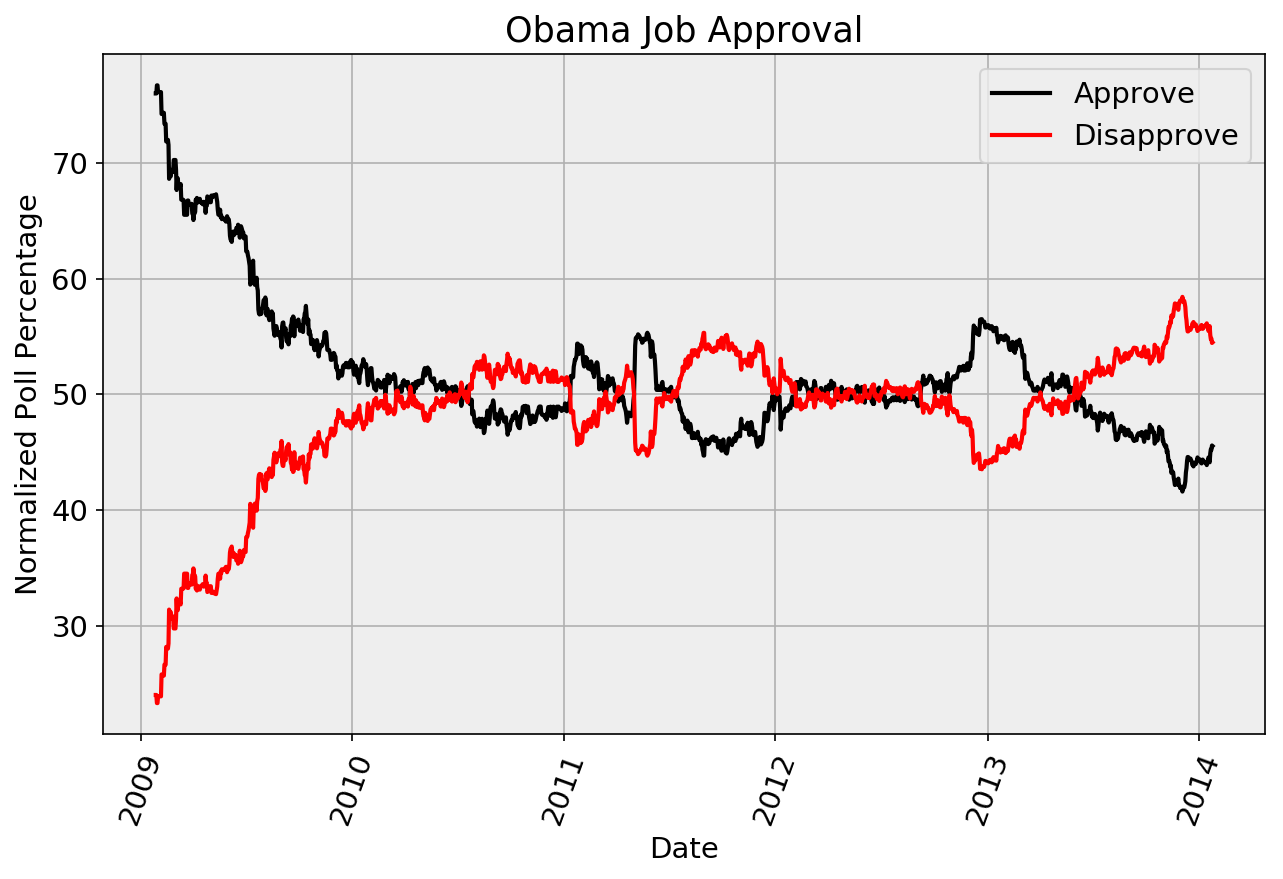

In [10]:
poll_plot(1044)
plt.title("Obama Job Approval")

---

## Part 2: Aggregate and Visualize


#### Problem 3

Unfortunately, these data don't have any error bars. If a candidate leads by 10% in the RCP average, is she a shoo-in to win? Or is this number too close to call? Does a 10% poll lead mean more 1 day before a race than it does 1 week before? Without error estimates, these questions are impossible to answer.

To get a sense of how accurate the RCP polls are, you will gather data from many previous Governor races, where the outcome is known.

This url has links to many governer races. 

http://www.realclearpolitics.com/epolls/2010/governor/2010_elections_governor_map.html

Notice that each link to a governor race has the following URL pattern:

http://www.realclearpolitics.com/epolls/[YEAR]/governor/[STATE]/[TITLE]-[ID].html


Below function scans html for links to URLs like this


In [14]:
"""
    Function
    --------
    find_governor_races

    Find and return links to RCP races on a page like
    http://www.realclearpolitics.com/epolls/2010/governor/2010_elections_governor_map.html
    
    Parameters
    ----------
    html : str
        The HTML content of a page to scan
        
    Returns
    -------
    A list of urls for Governer race pages
    
    Example
    -------
    For a page like
    
    <html>
    <body>
    <a href="http://www.realclearpolitics.com/epolls/2010/governor/ma/massachusetts_governor_baker_vs_patrick_vs_cahill-1154.html"></a>
    <a href="http://www.realclearpolitics.com/epolls/2010/governor/ca/california_governor_whitman_vs_brown-1113.html"></a>
    </body>
    </html>
    
    find_governor_races would return
    ['http://www.realclearpolitics.com/epolls/2010/governor/ma/massachusetts_governor_baker_vs_patrick_vs_cahill-1154.html',
     'http://www.realclearpolitics.com/epolls/2010/governor/ca/california_governor_whitman_vs_brown-1113.html']
"""

def find_governor_races(url):
    link = urllib.request.urlopen(url).read()
    soup = bs4.BeautifulSoup(link)
    allLinks = [l.get('href') for l in soup.find_all('a')]
    electionLinks = ['https://www.realclearpolitics.com'+l for l in allLinks if l is not None and l[:7] == "/epolls"]
    time.sleep(60)
    return electionLinks



#### Problem 4

At this point, you have functions to find a collection of governor races, download historical polling data from each one,
parse them into a numerical DataFrame, and plot this data.

The main question we have about these data are how accurately they predict election outcomes. To answer this question, we
need to grab the election outcome data.

Below function looks up and returns the election result on a page like [this one](http://www.realclearpolitics.com/epolls/2010/governor/ca/california_governor_whitman_vs_brown-1113.html). 


In [13]:
"""
    Function
    --------
    race_result

    Return the actual voting results on a race page
    
    Parameters
    ----------
    url : string
        The website to search through
        
    Returns
    -------
    A dictionary whose keys are candidate names,
    and whose values is the percentage of votes they received.
    
    If necessary, normalize these numbers so that they add up to 100%.
    
    Example
    --------
    >>> url = 'http://www.realclearpolitics.com/epolls/2010/governor/ca/california_governor_whitman_vs_brown-1113.html'
    >>> race_result(url)
    {'Brown': 56.0126582278481, 'Whitman': 43.9873417721519}
"""

def race_result(input):
    link = urllib.request.urlopen(input).read()
    soup = bs4.BeautifulSoup(link)
    table = soup.find('div', id = 'polling-data-rcp')
    headers = [l.text for l in table.find_all('th')[3:-1]]
    rows = [l.text for l in table.find('tr', {"class" : "final"}).find_all('td')[3:-1] ]
    data = dict(zip(headers, rows))
    return data



In [16]:
def id_from_url(url):
    """Given a URL, look up the RCP identifier number"""
    return url.split('-')[-1].split('.html')[0]


def plot_race(url):
    """Make a plot summarizing a senate race
    
    Overplots the actual race results as dashed horizontal lines
    """
    #hey, thanks again for these functions!
    id = id_from_url(url)
    xml = get_poll_xml(id)    
    colors = plot_colors(xml)

    if len(colors) == 0:
        return
    
    #really, you shouldn't have
    result = race_result(url)
    poll_plot(id)
    plt.xlabel("Date")
    plt.ylabel("Polling Percentage")
    for (k,v), (k2,v2) in zip(result.items(), colors.items()):
        plt.axhline(float(v), color=v2, alpha=0.6, ls='--')
        


Now that this is done, we can easily visualize many historical Governer races. The solid line plots the poll history, the dotted line reports the actual result.

If this code block fails, you probably have a bug in one of your functions.

C:\Users\Srikanth Goli\Anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\Srikanth Goli\Anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


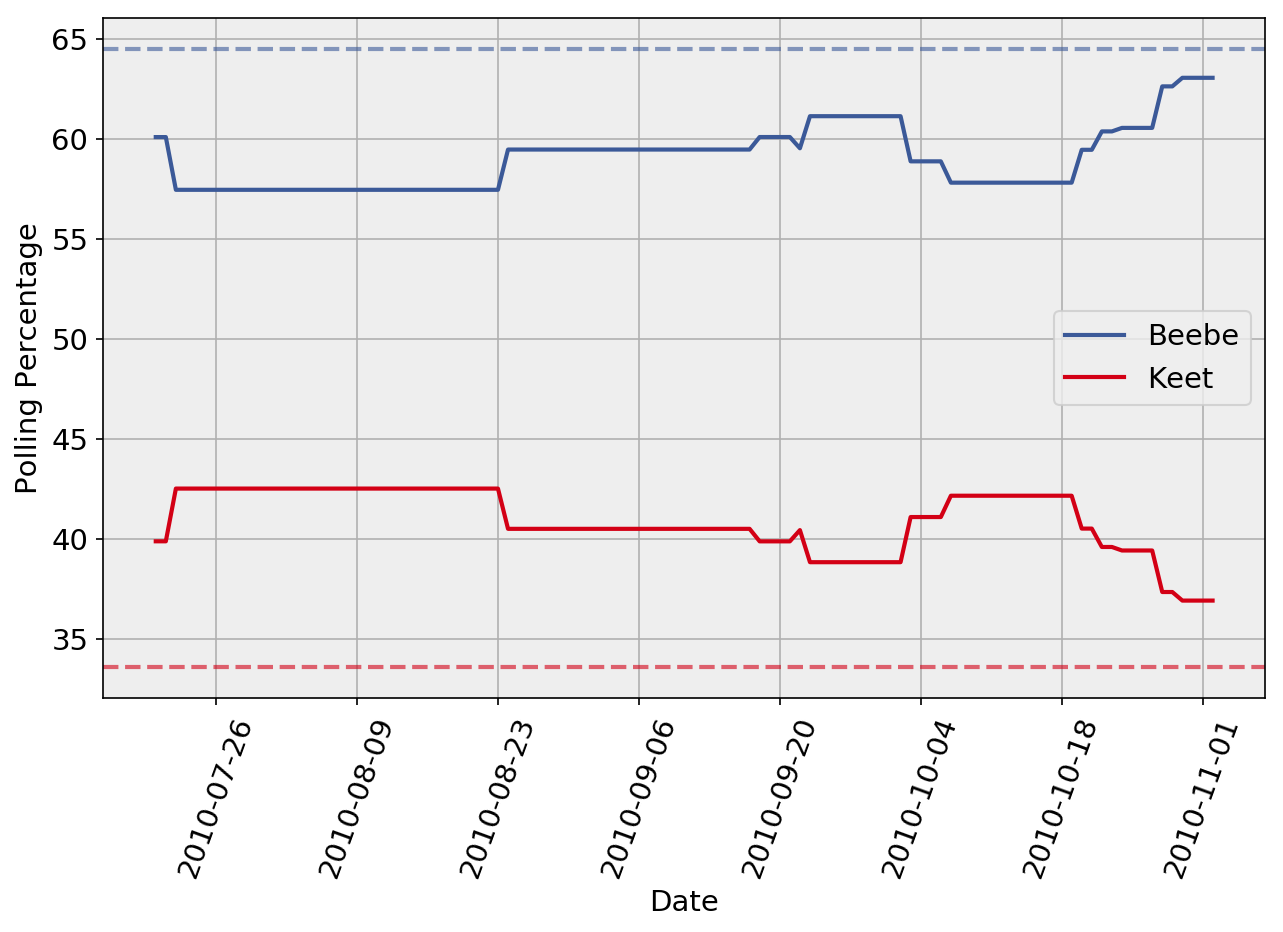

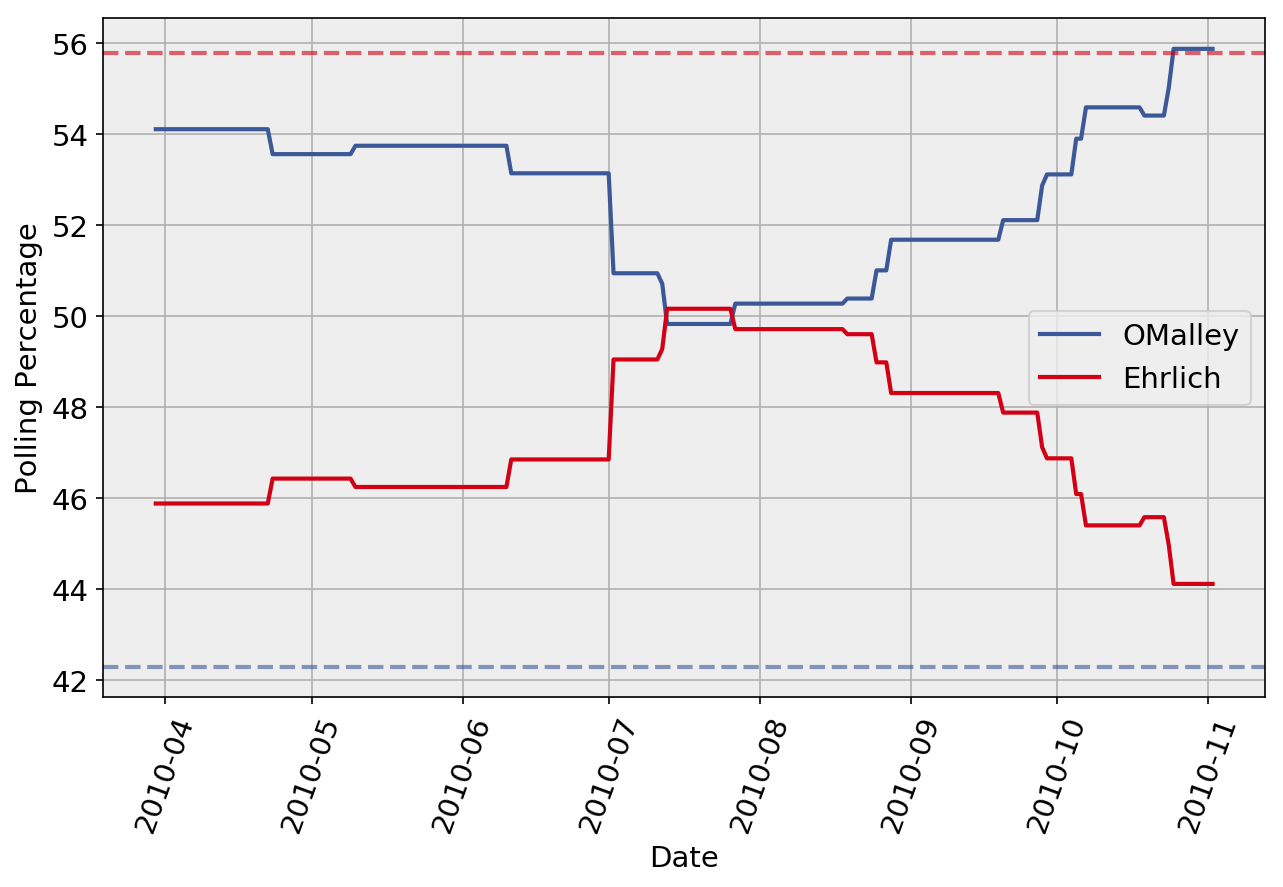

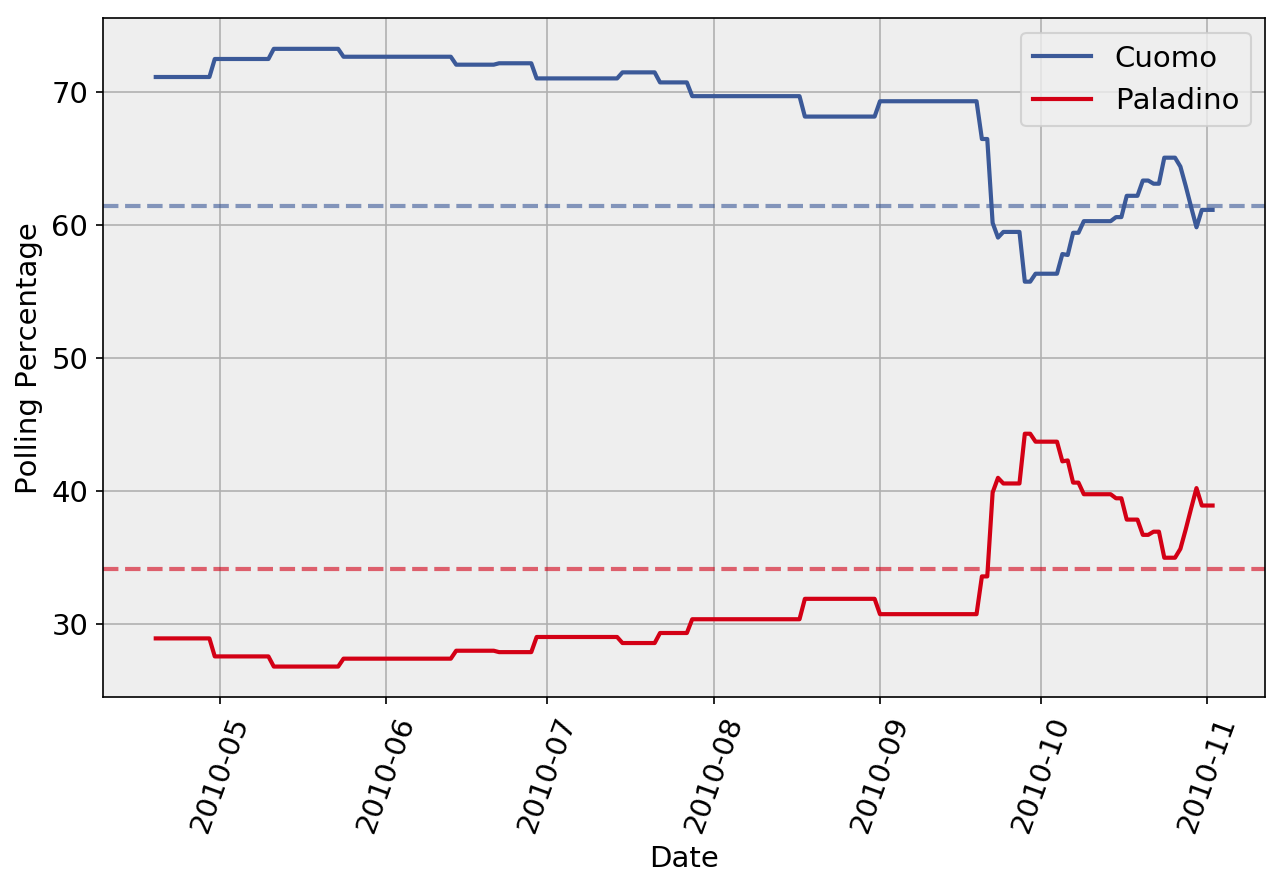

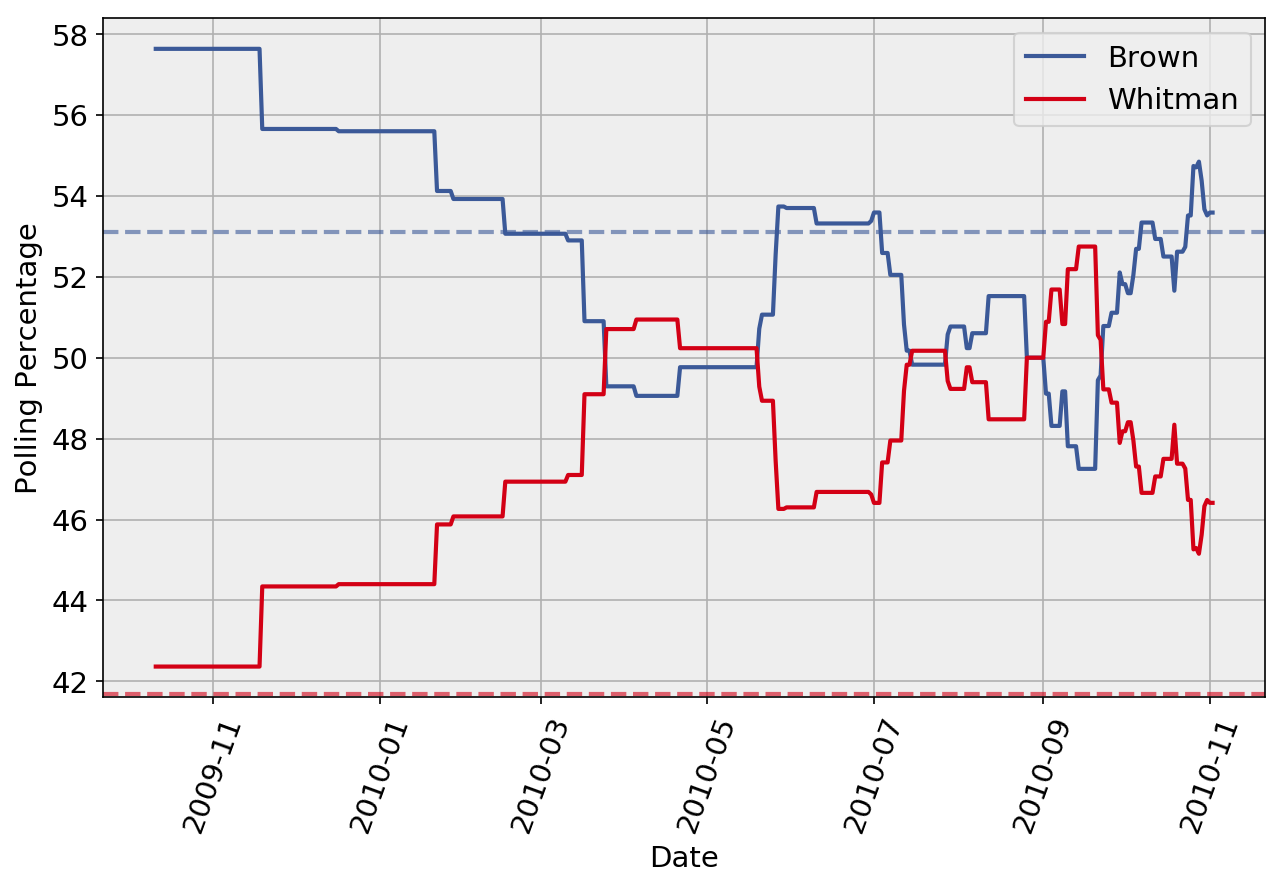

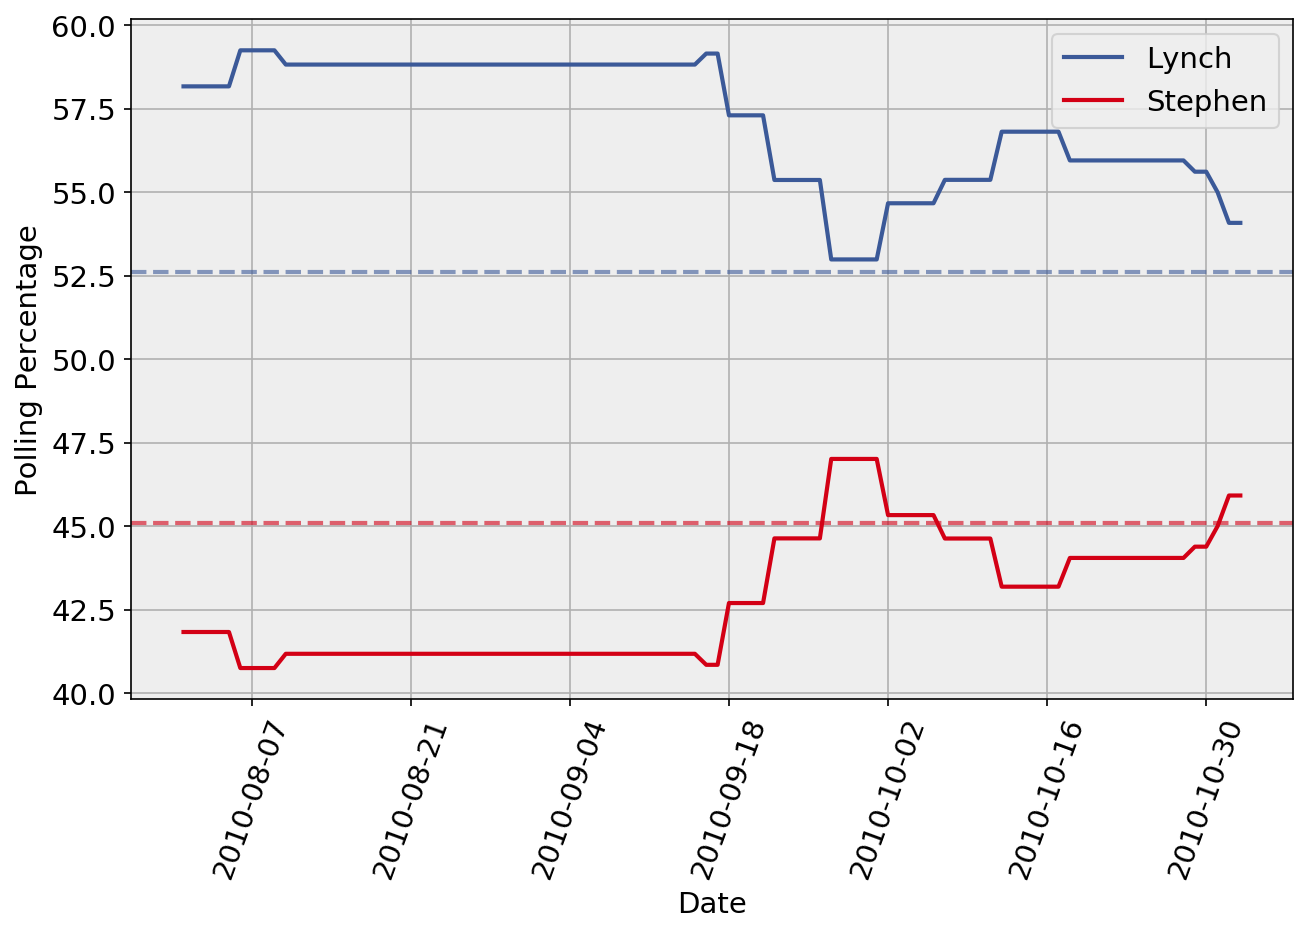

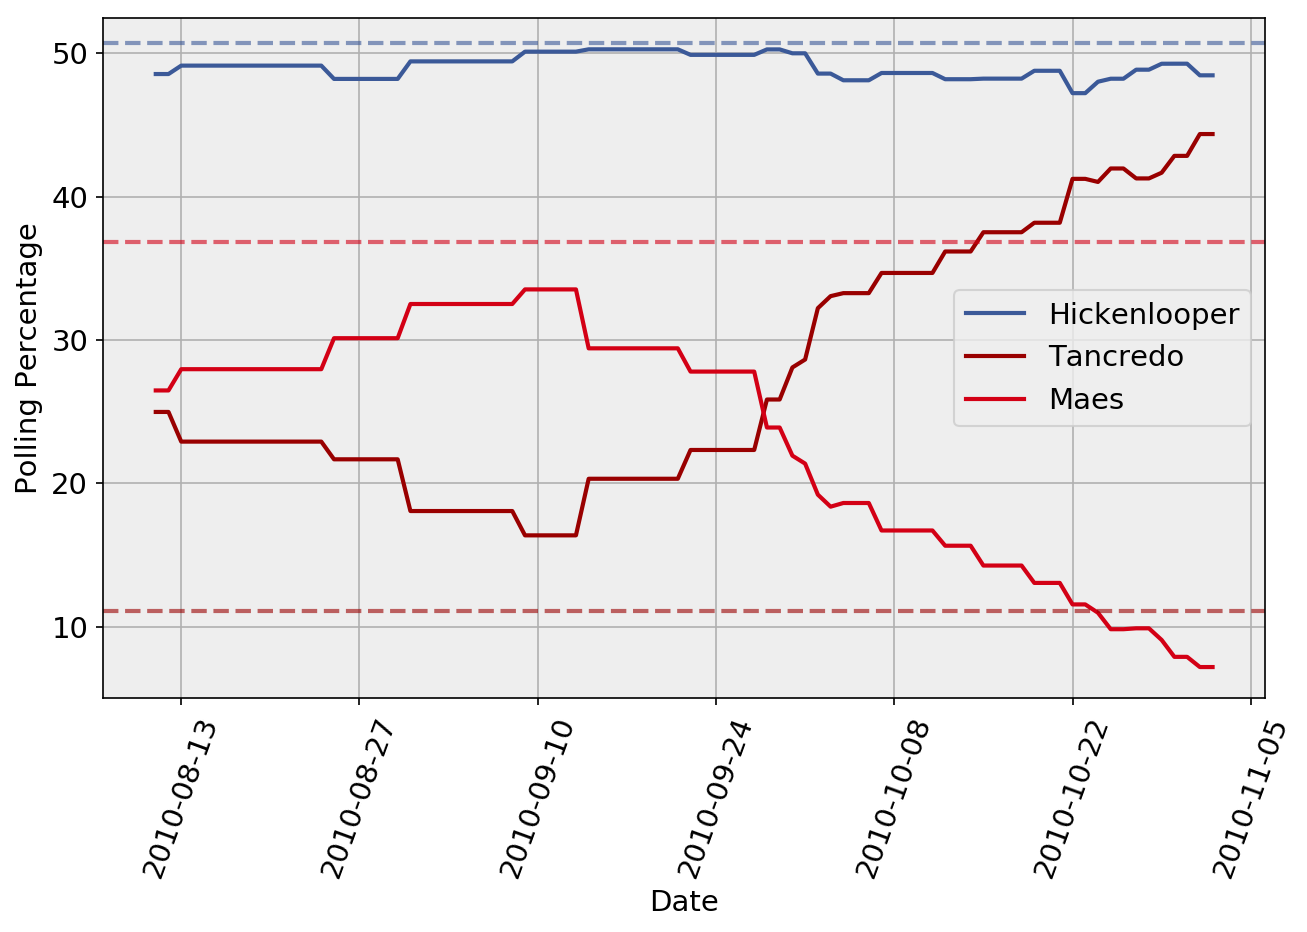

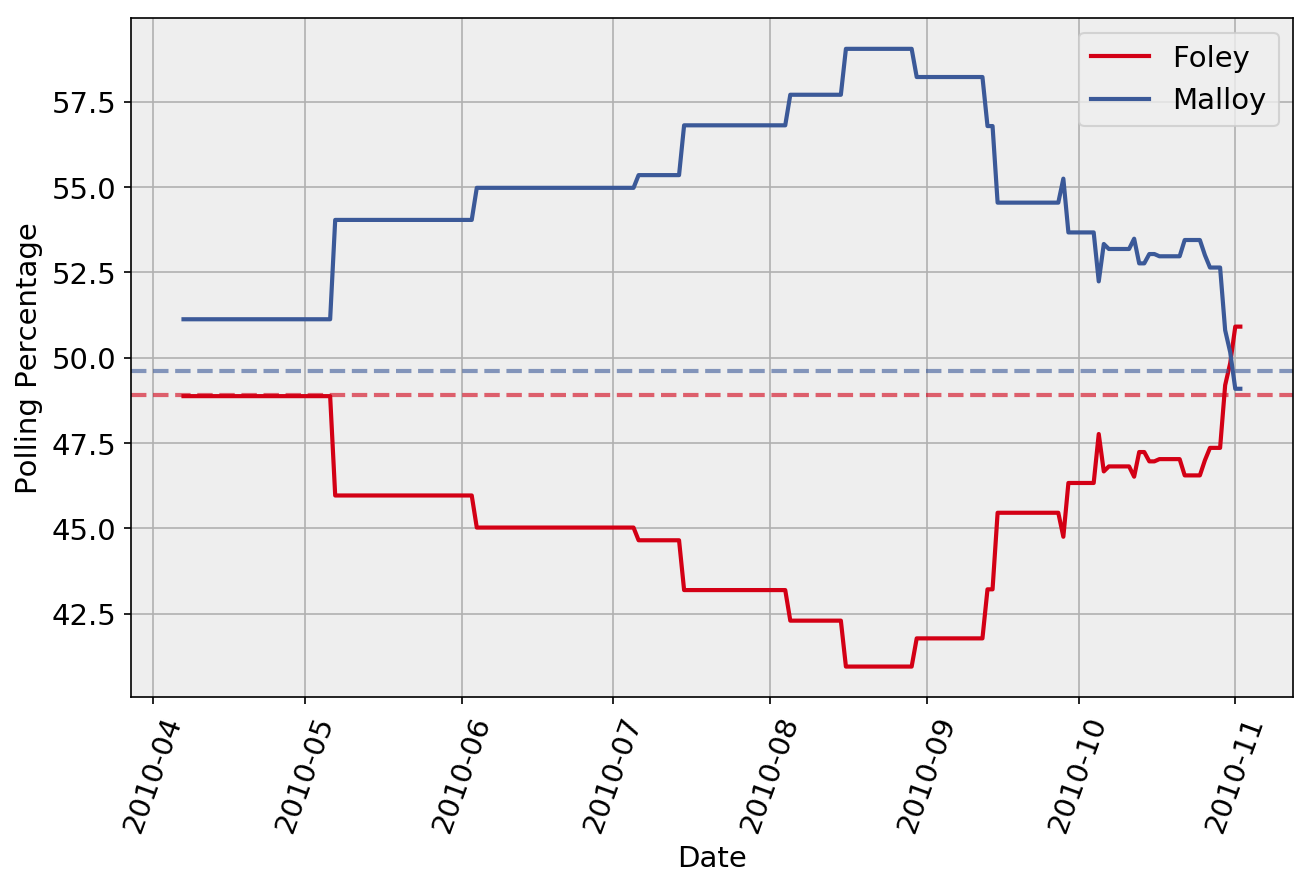

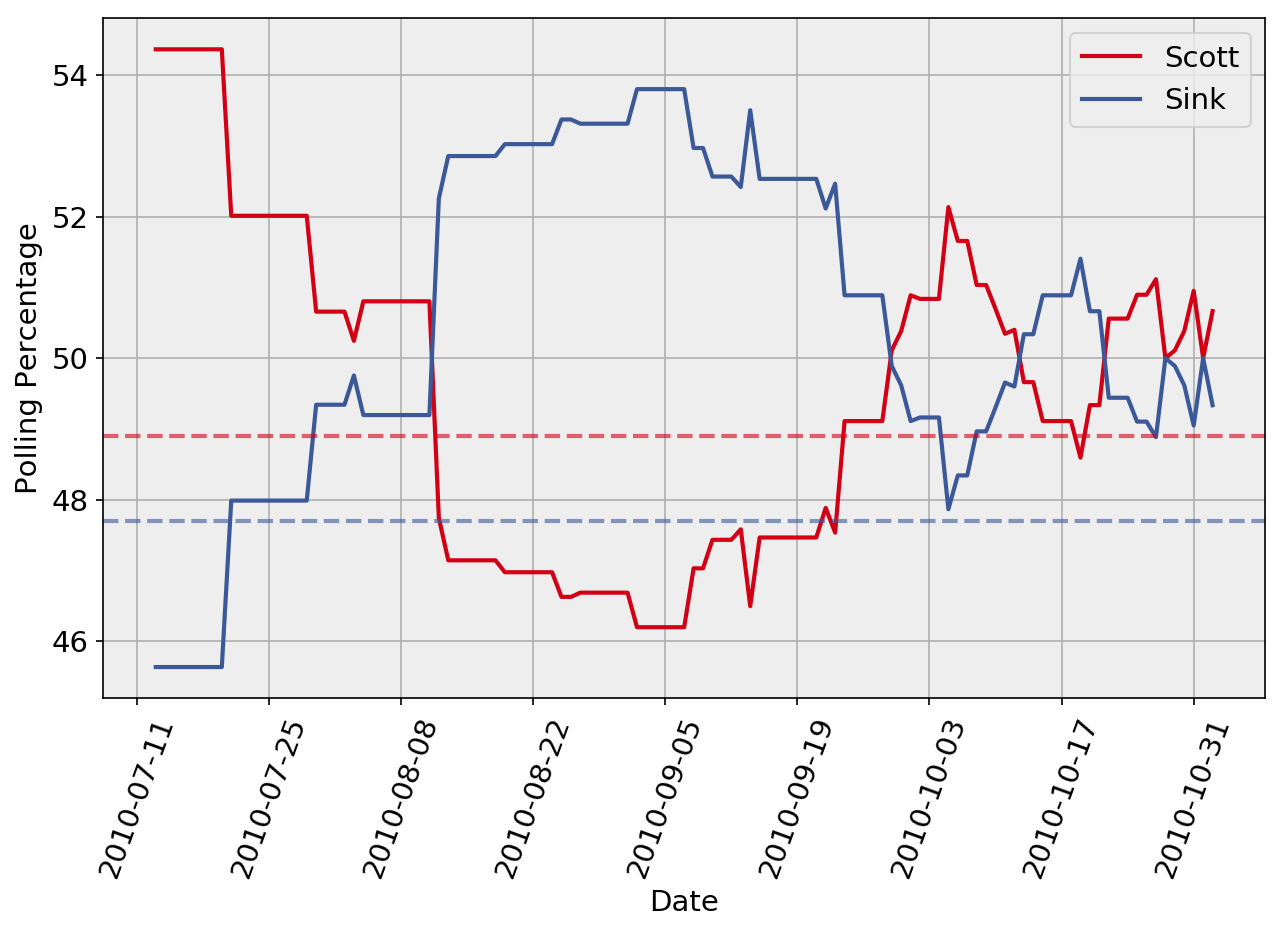

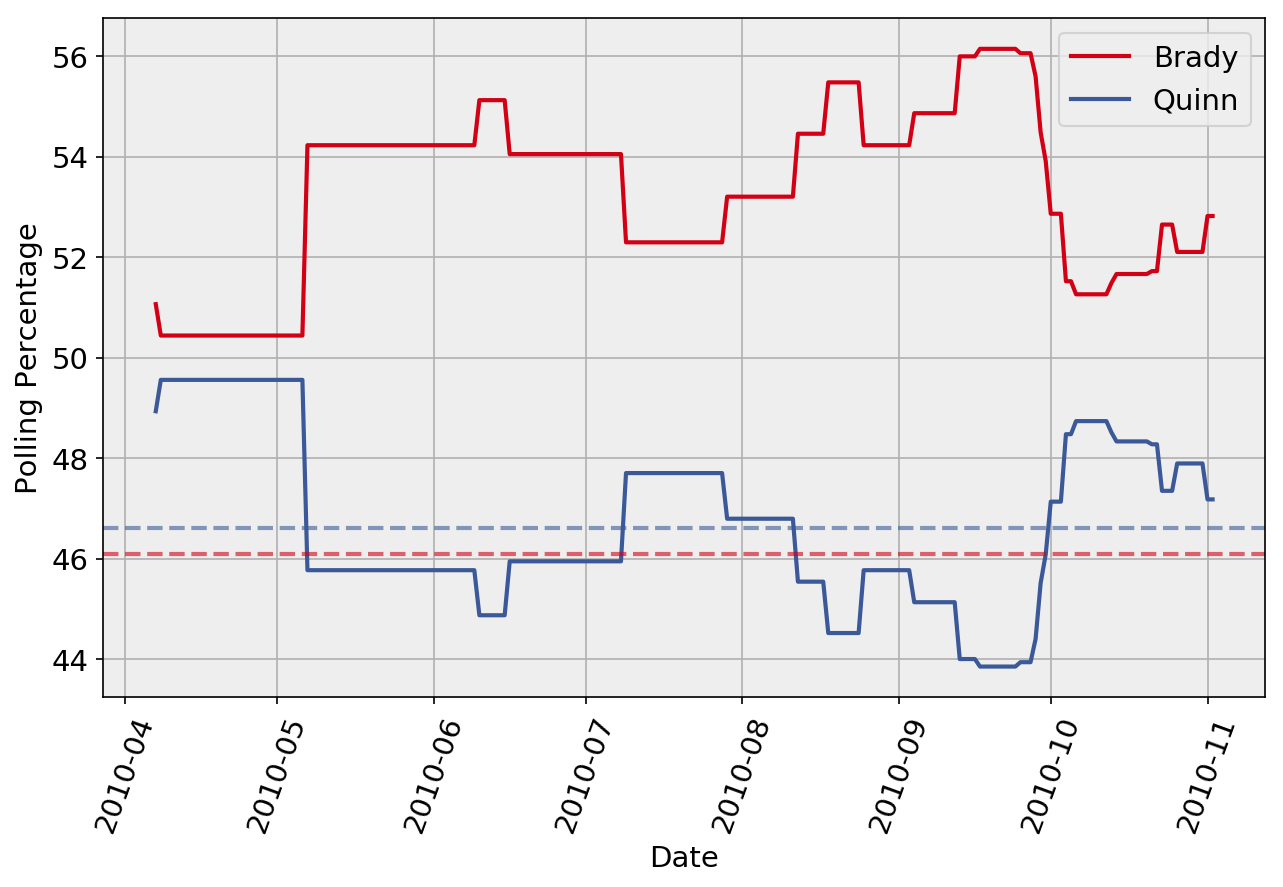

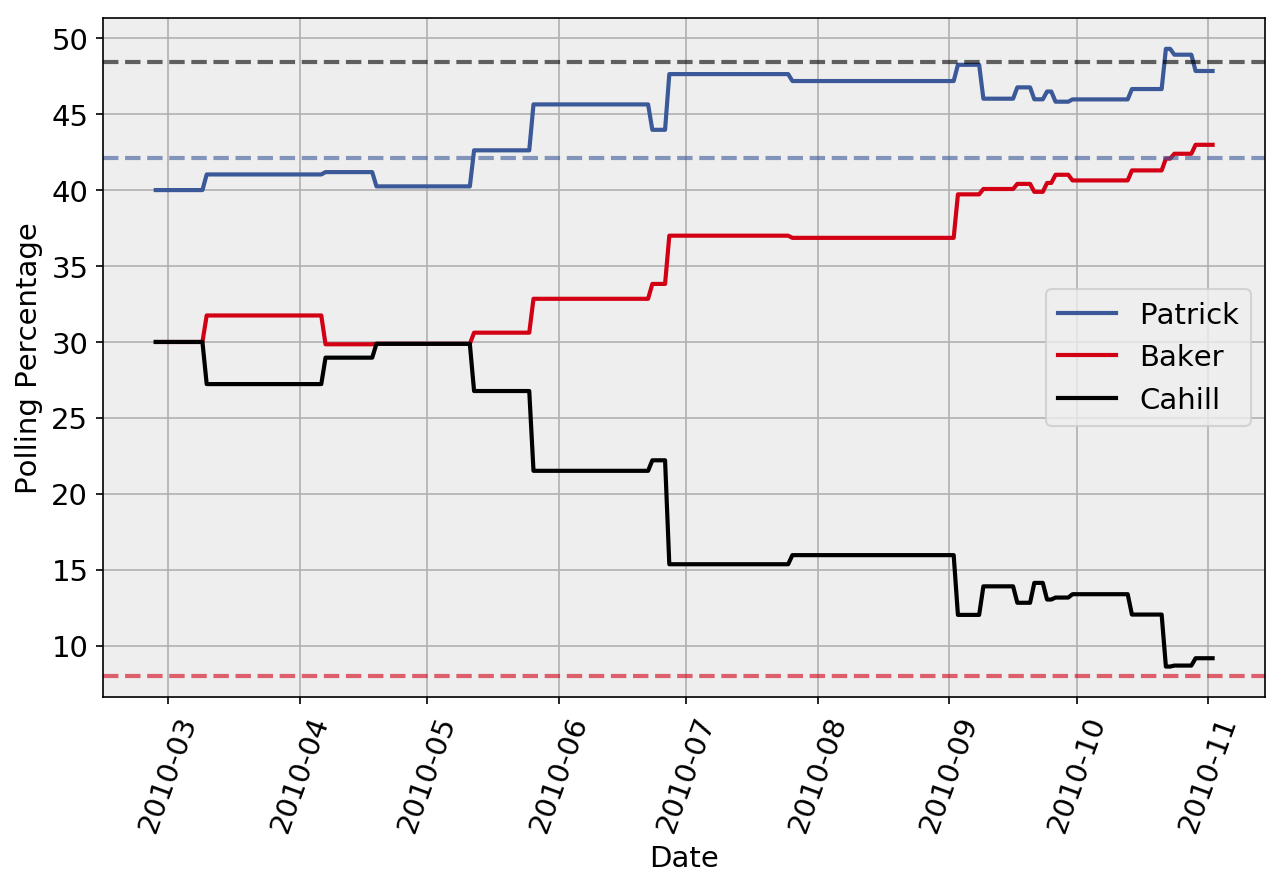

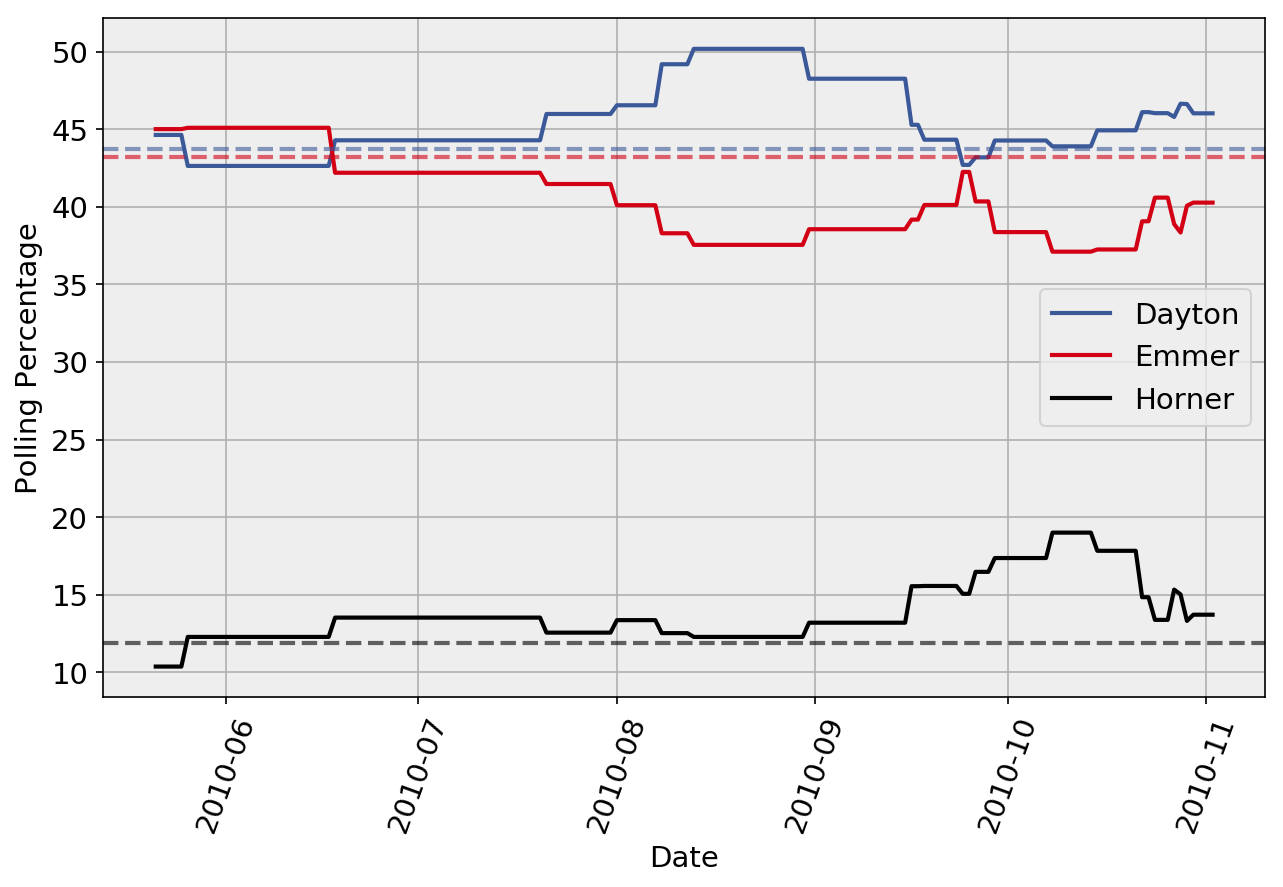

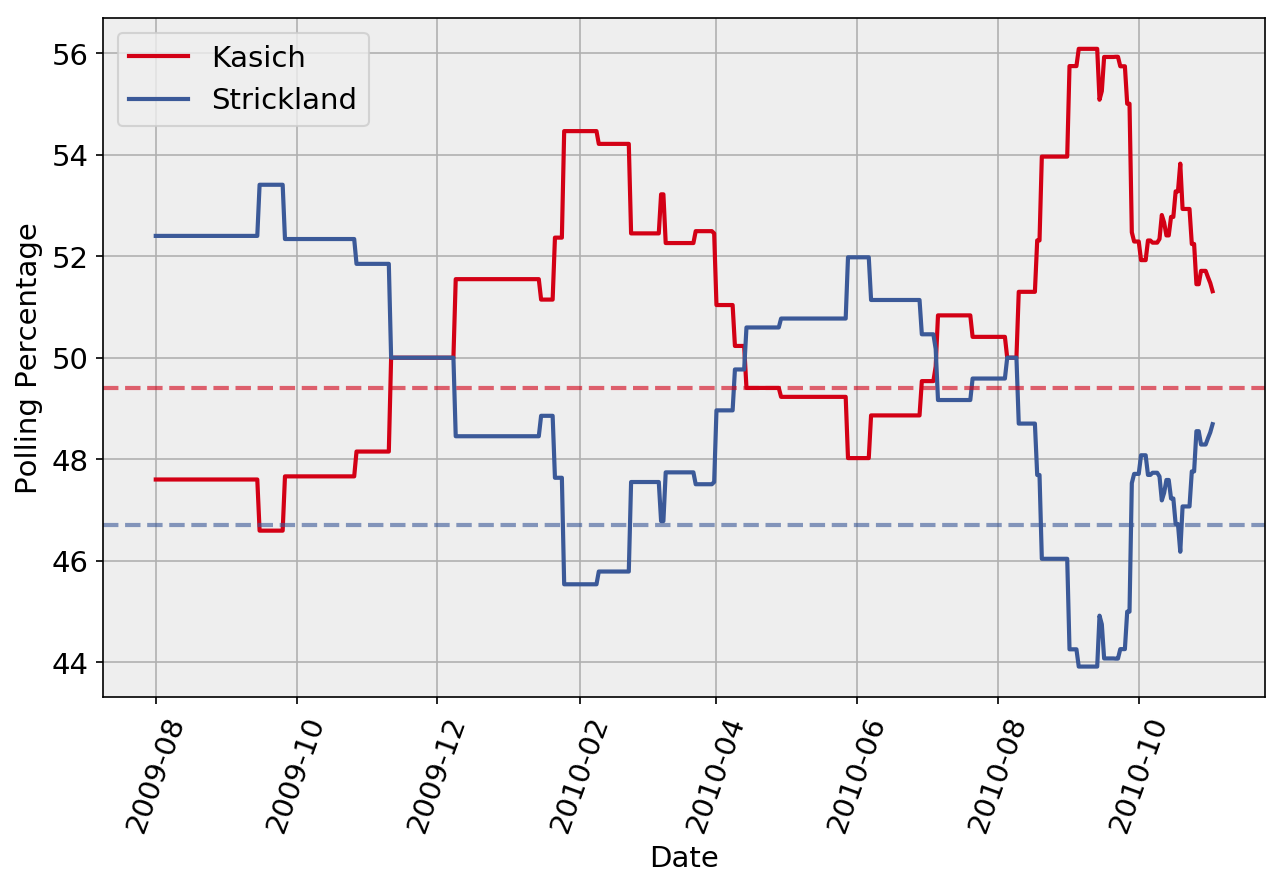

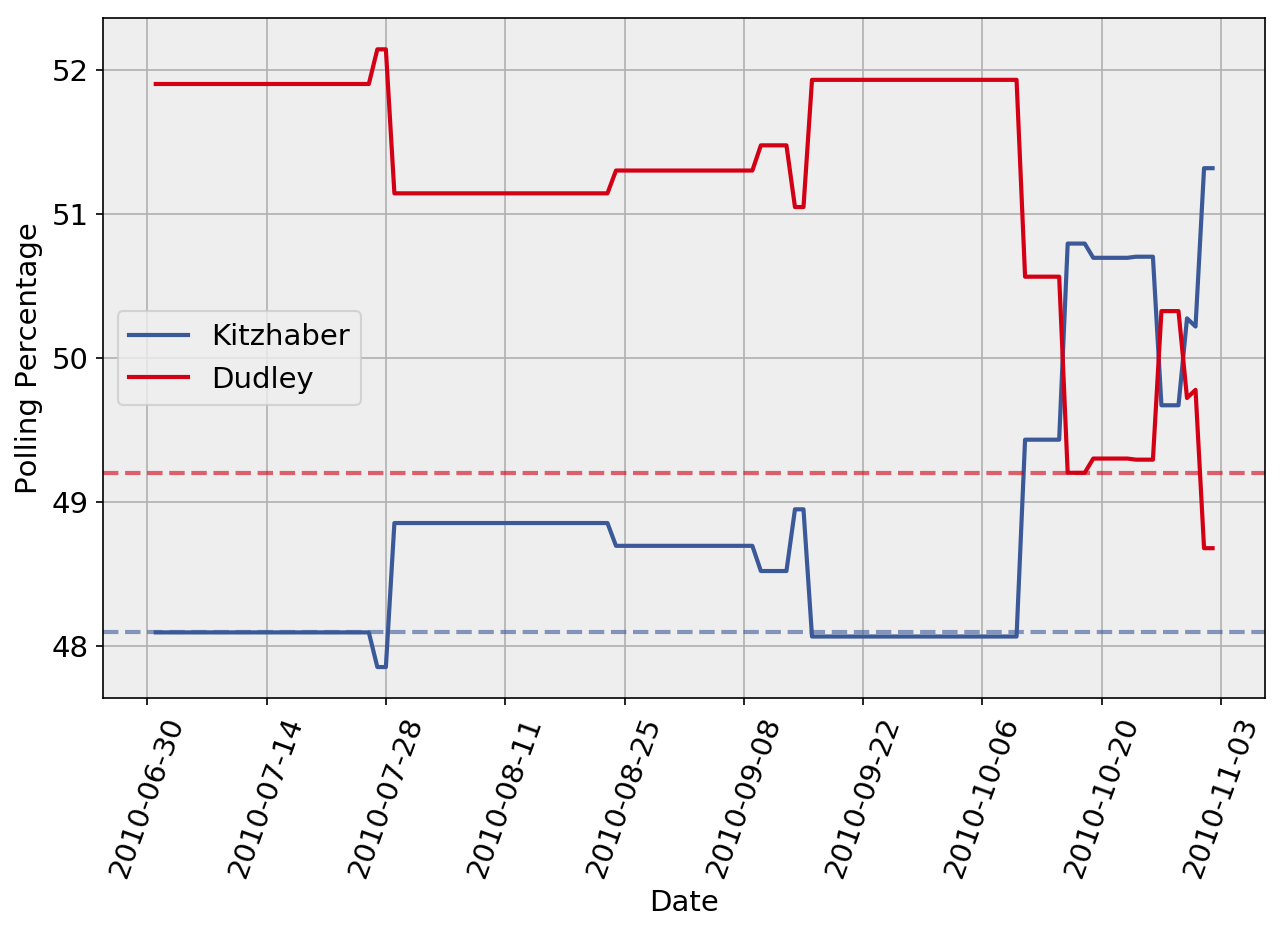

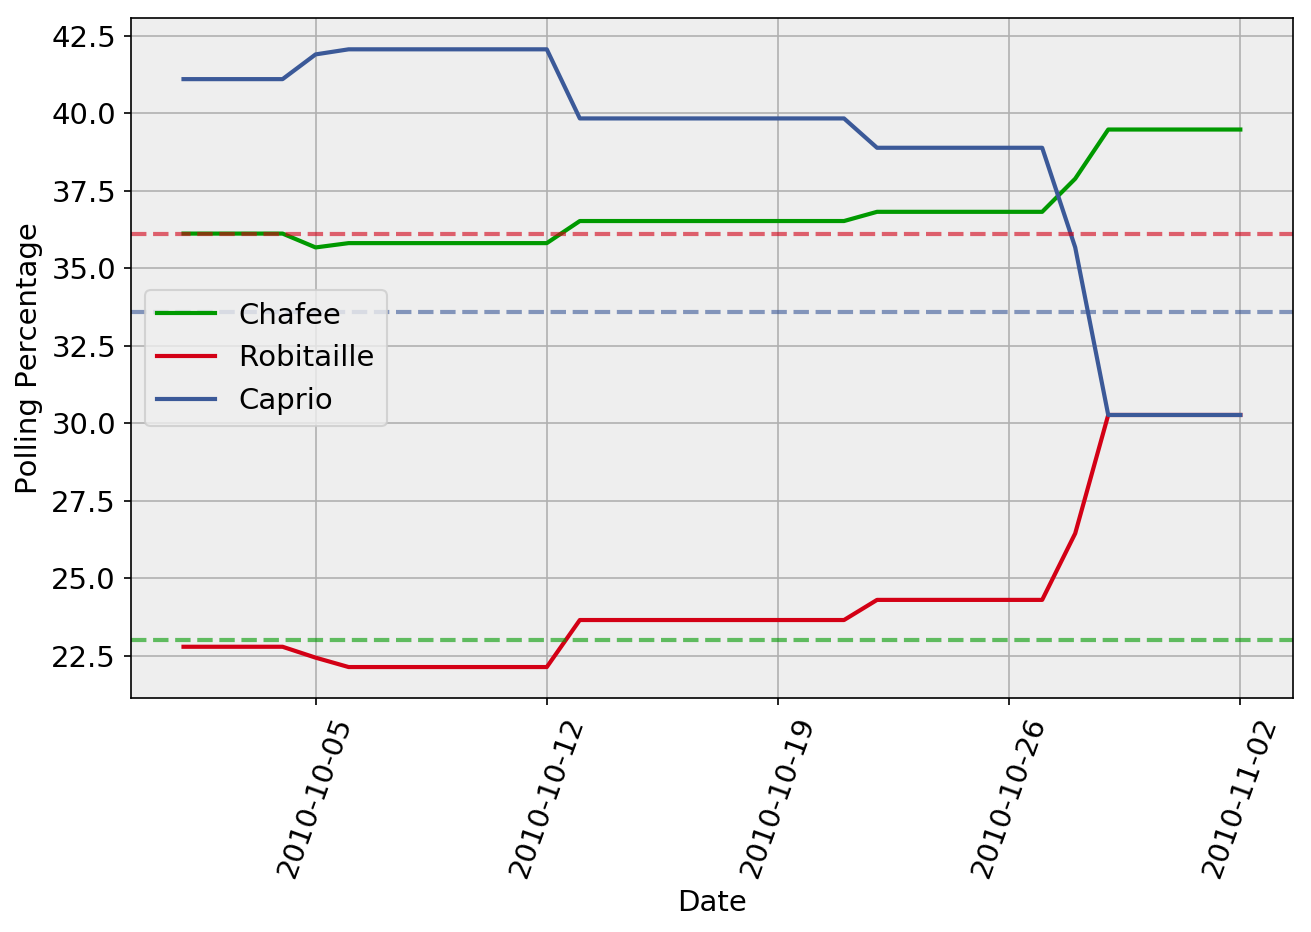

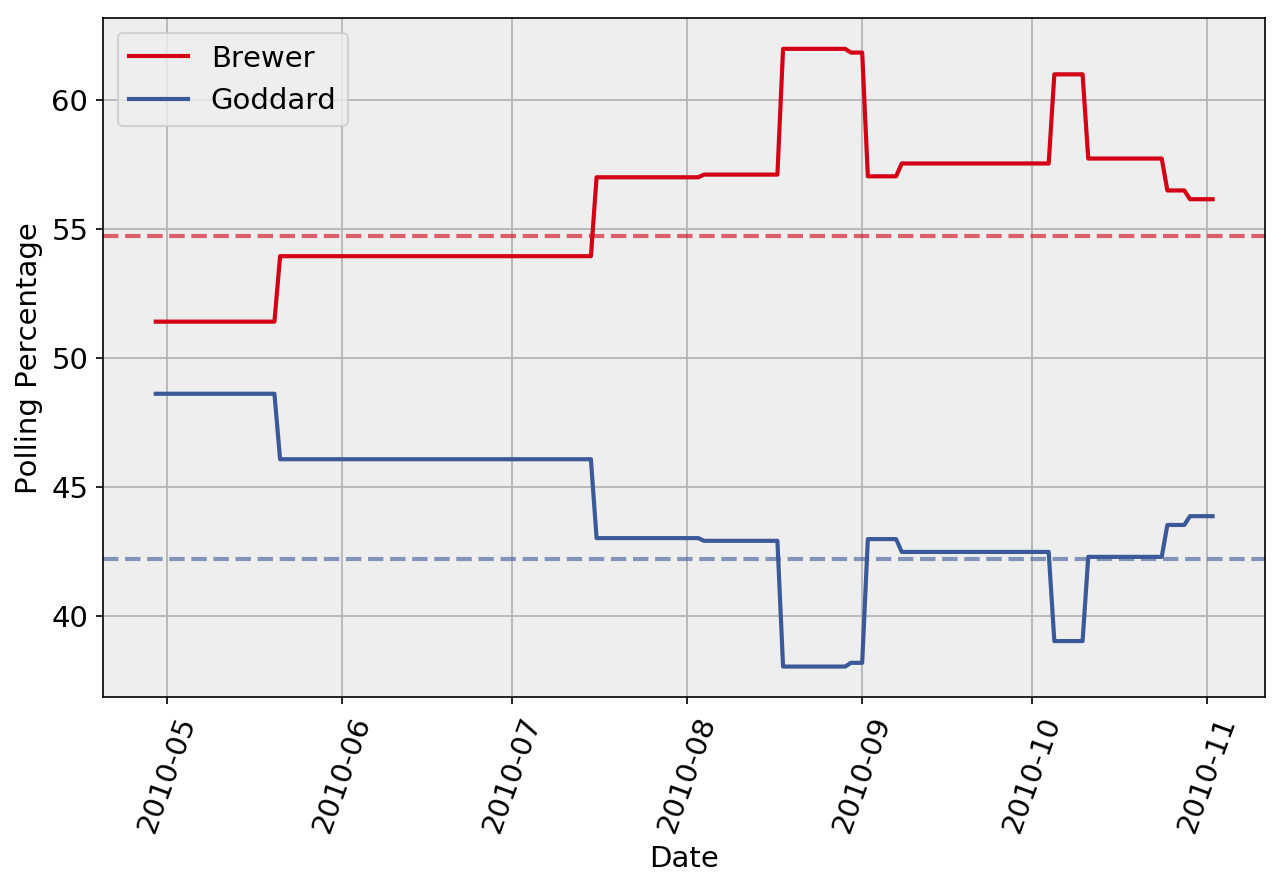

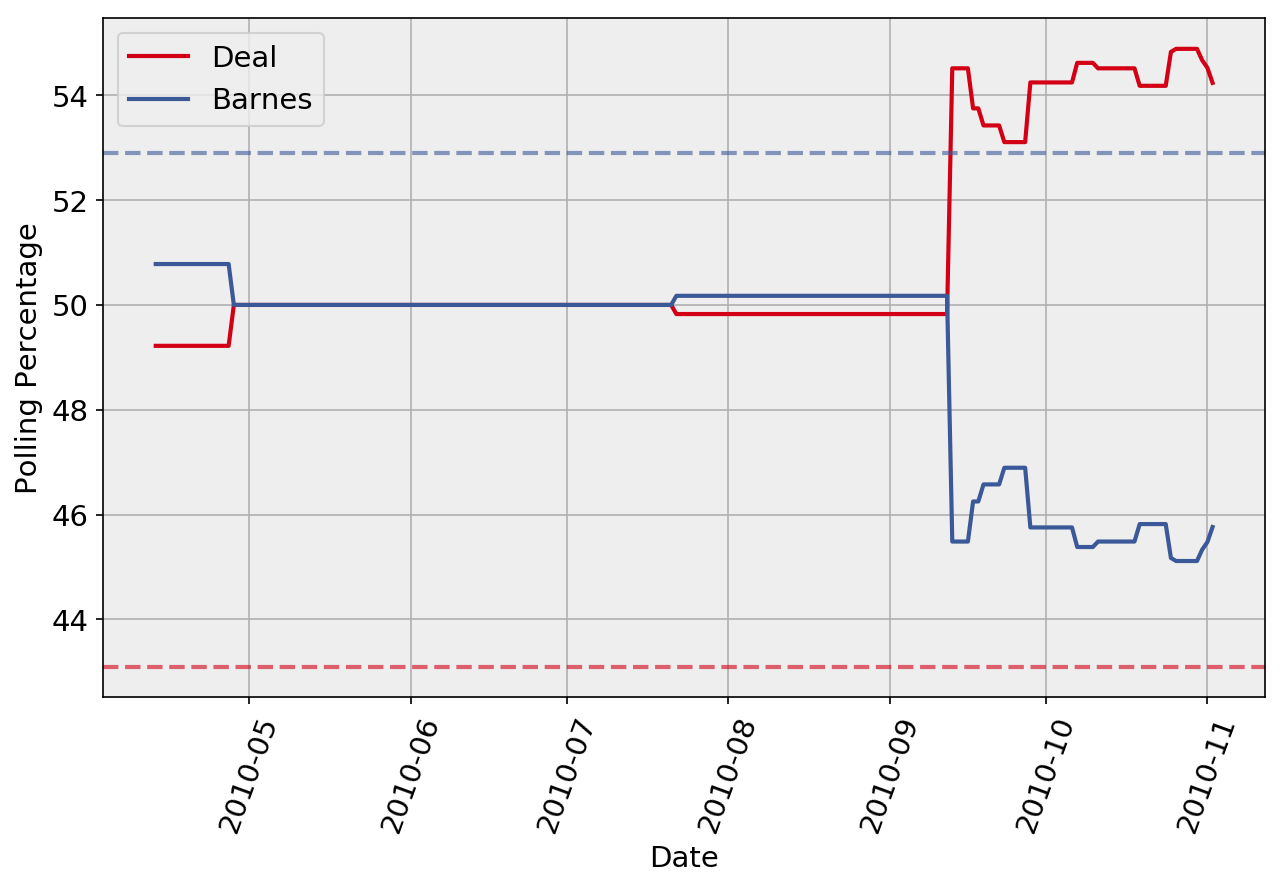

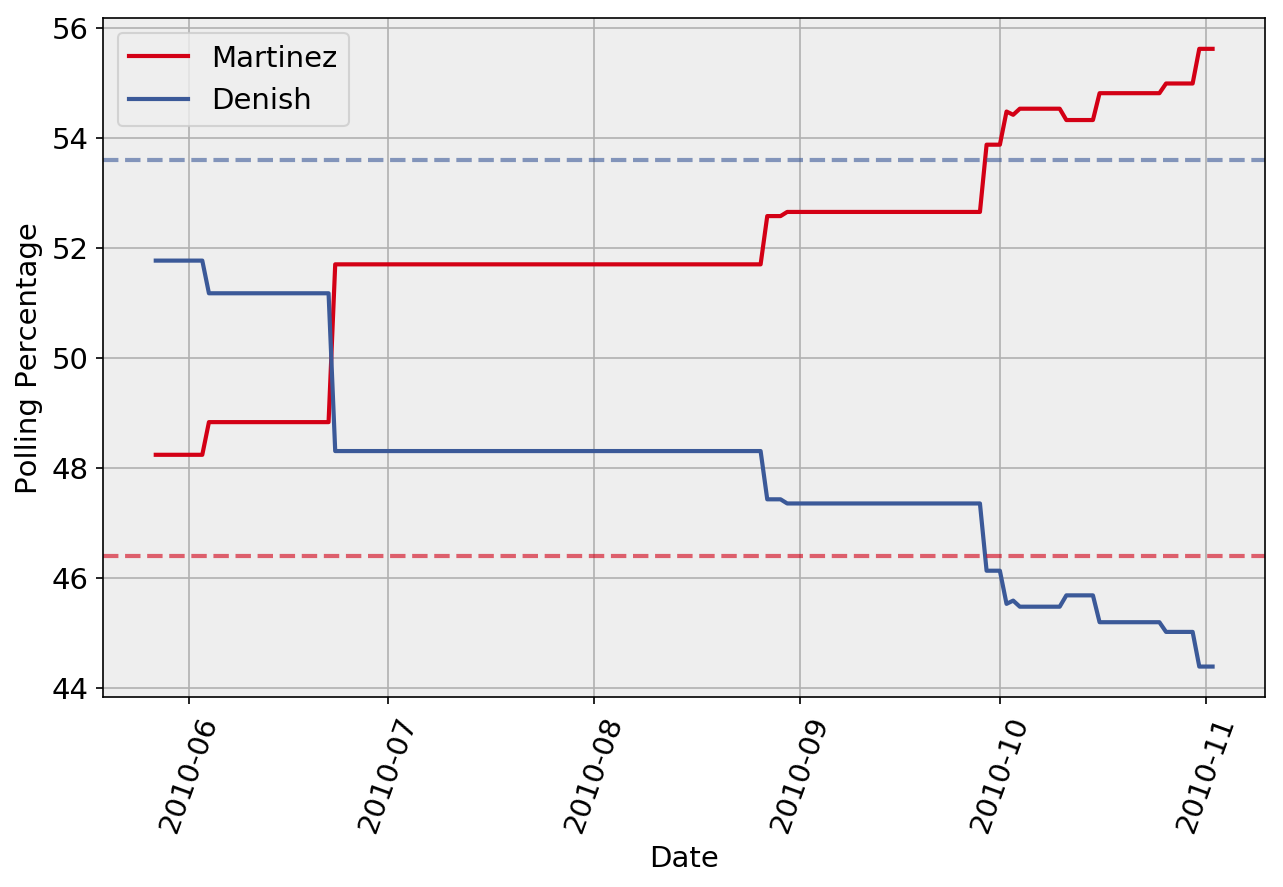

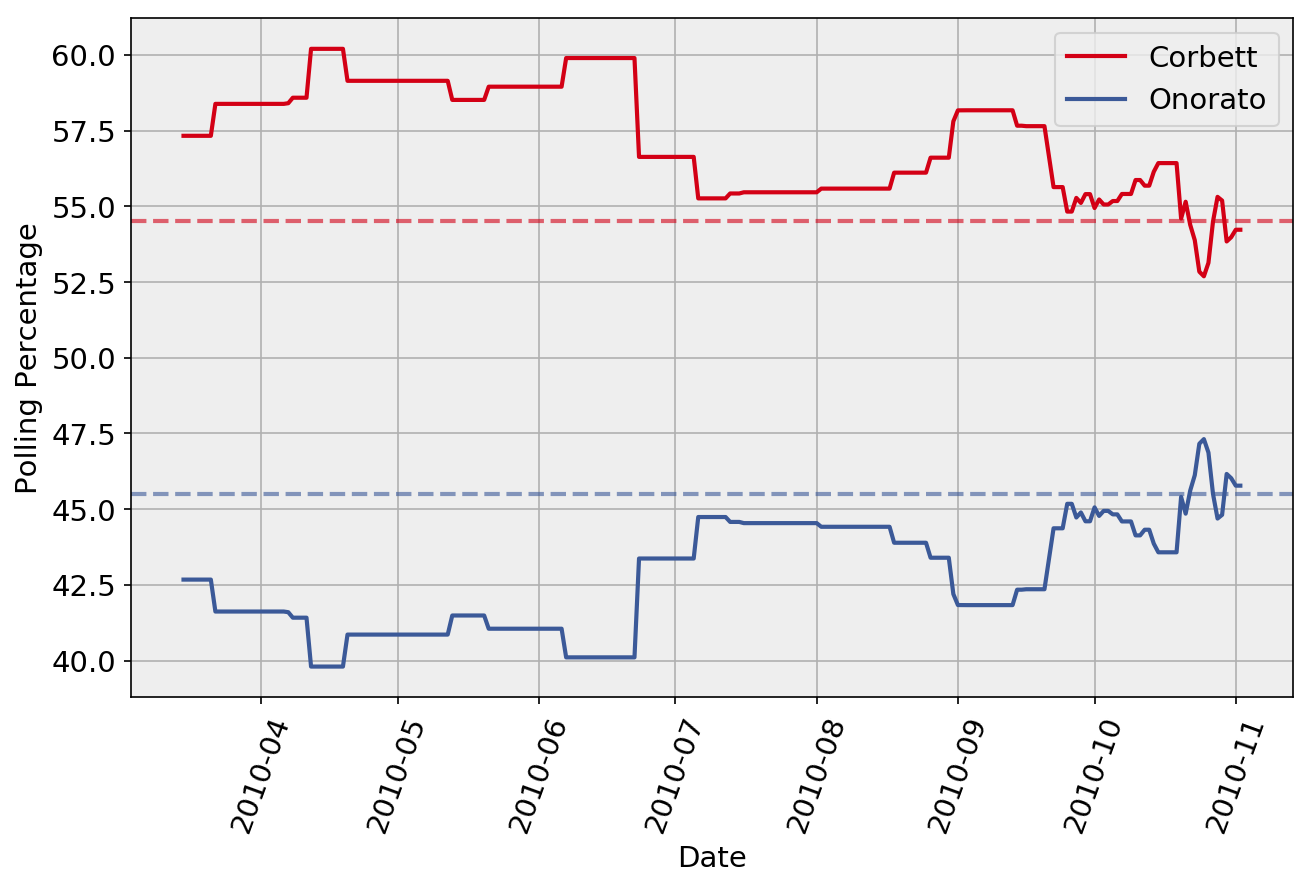

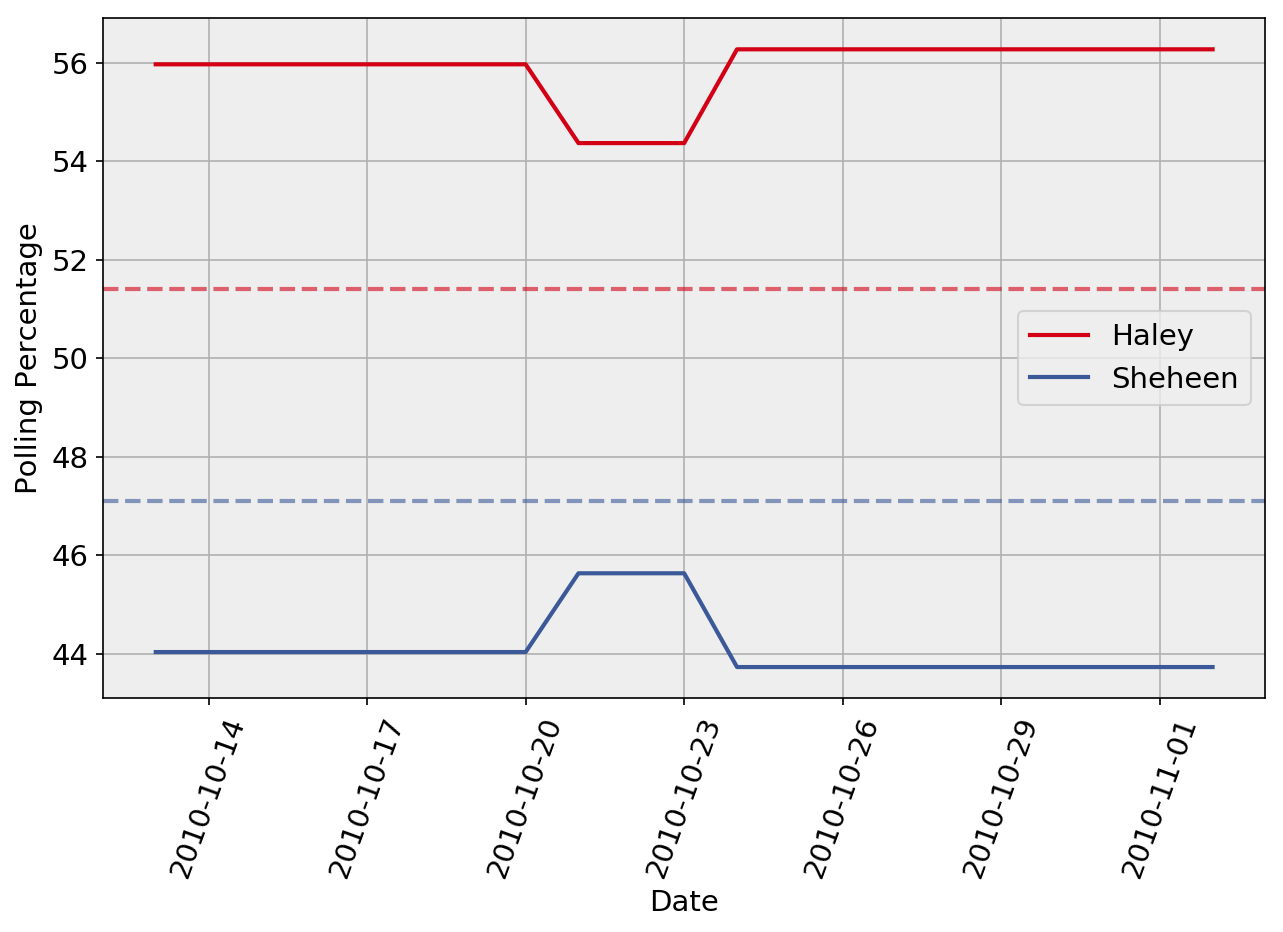

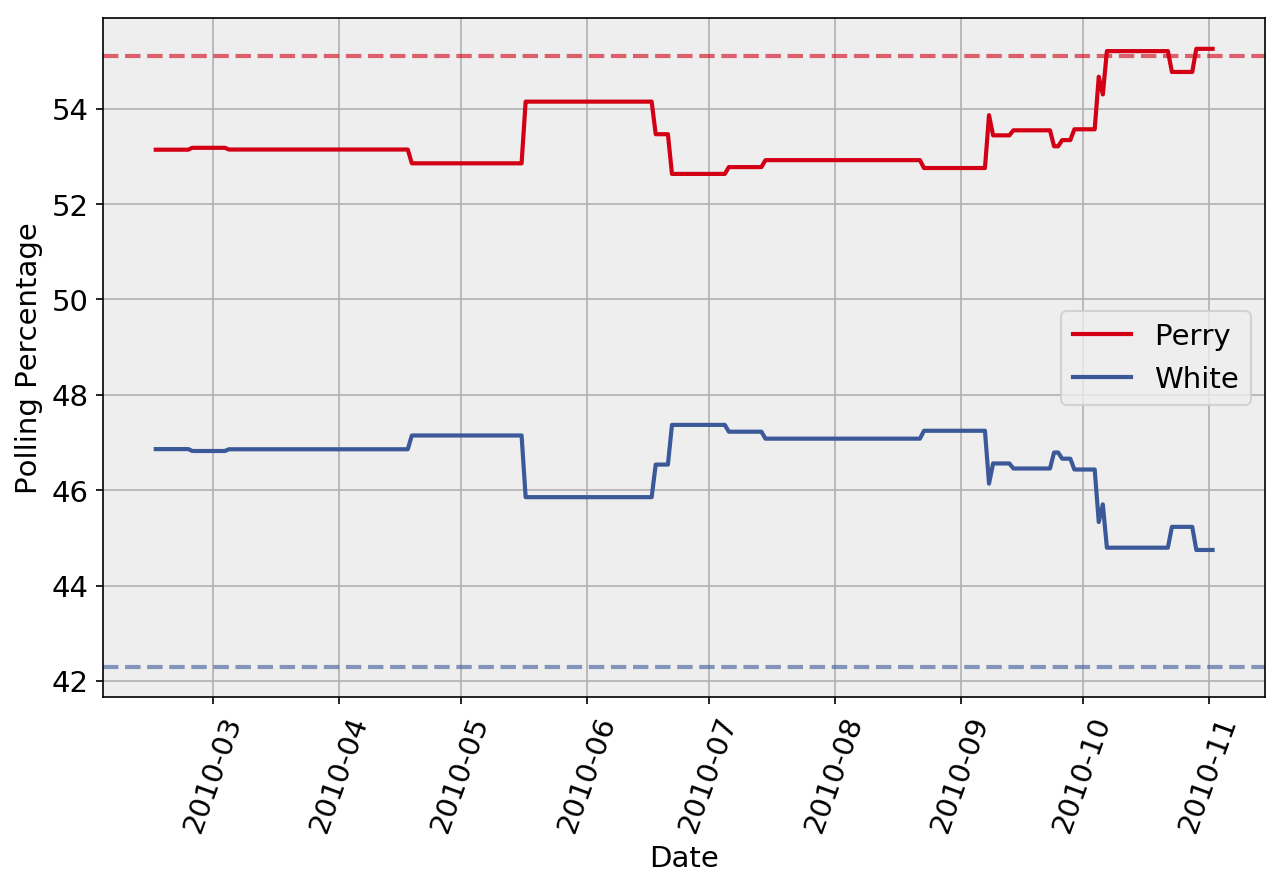

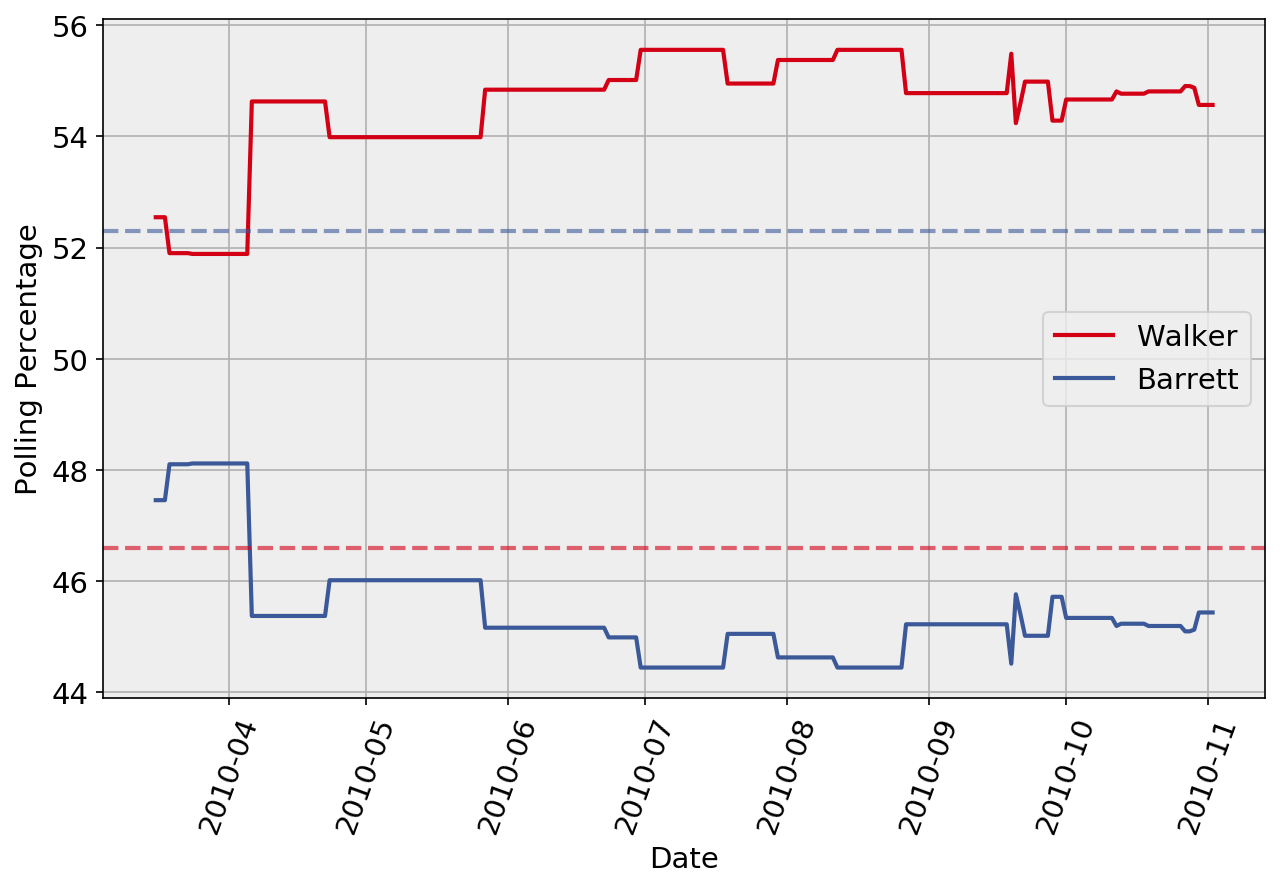

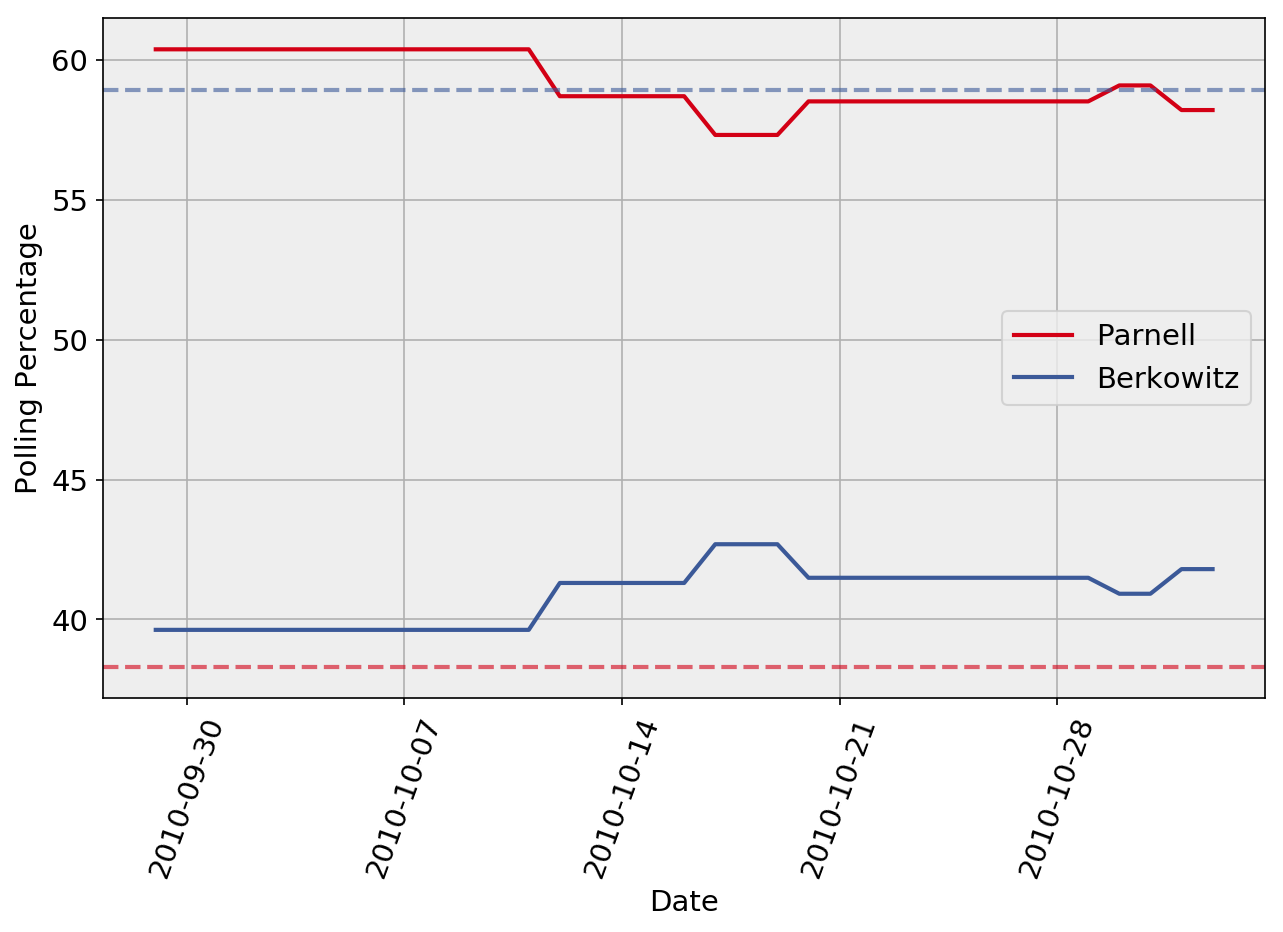

URLError: <urlopen error [Errno 11001] getaddrinfo failed>

In [17]:
page = 'http://www.realclearpolitics.com/epolls/2010/governor/2010_elections_governor_map.html'
for race in find_governor_races(page):
    plot_race(race)
    plt.show()
    time.sleep(60)


From the above graphs, we can observe that the accuracy is with-in 10% of the final election result. Also, the accuracy rate is very high for the polls which are taken right before couple of days of original elections.

---

## Part 3: Analysis


Using `error_data`, `find_governer_races`, and `pd.concat` to construct a Data Frame summarizing the forecast errors
from all the Governor races


In [ ]:
def party_from_color(color):
    if color in ['#0000CC', '#3B5998']:
        return 'democrat'
    if color in ['#FF0000', '#D30015']:
        return 'republican'
    return 'other'


def error_data(url):
    """
    Given a Governor race URL, download the poll data and race result,
    and construct a DataFrame with the following columns:
    
    candidate: Name of the candidate
    forecast_length: Number of days before the election
    percentage: The percent of poll votes a candidate has.
                Normalized to that the canddidate percentages add to 100%
    error: Difference between percentage and actual race reulst
    party: Political party of the candidate
    
    The data are resampled as necessary, to provide one data point per day
    """
    
    id = id_from_url(url)
    xml = get_poll_xml(id)
    
    colors = plot_colors(xml)
    if len(colors) == 0:
        return pd.DataFrame()
    
    df = rcp_poll_data(xml)
    result = race_result(url)
    
    #remove non-letter characters from columns
    df = df.rename(columns={c: _strip(c) for c in df.columns})

    for k, v in result.items():
        result[_strip(k)] = result.pop(k) 

    for k, v in colors.items():
        colors[_strip(k)] = colors.pop(k) 
    
    candidates = [c for c in df.columns if c is not 'Date']
    
    for c in candidates:
        df[c] = df[c].astype(float)  

    #turn into a timeseries...
    df.index = df.Date

    #...so that we can resample at regular, daily intervals
    df = df.resample('D')
    df = df.dropna()
    
    #compute forecast length in days
    #(assuming that last forecast happens on the day of the election, for simplicity)
    forecast_length = (df.index.max() - df.index)
    forecast_length = forecast_length / np.timedelta64(1, 'D')  # convert to number of days
    
    #compute forecast error
    errors = {}
    normalized = {}
    poll_lead = {}

    
    for c in candidates:
        #turn raw percentage into percentage of poll votes
        corr = df[c].values / df[candidates].sum(axis=1).values * 100.
        err = corr - float(result[c])
        
        normalized[c] = corr
        errors[c] = err
        
    n = forecast_length.size
    result = {}
    result['percentage'] = np.hstack(normalized[c] for c in candidates)
    result['error'] = np.hstack(errors[c] for c in candidates)
    result['candidate'] = np.hstack(np.repeat(c, n) for c in candidates)
    result['party'] = np.hstack(np.repeat(party_from_color(colors[c]), n) for c in candidates)
    result['forecast_length'] = np.hstack(forecast_length for _ in candidates)
    
    result = pd.DataFrame(result)
    return result


In [ ]:
"""
function
---------
all_error_data

Calls error_data on all races from find_governer_races(page),
and concatenates into a single DataFrame

Parameters
-----------
None

Examples
--------
df = all_error_data()
"""
test = ['http://www.realclearpolitics.com/epolls/2010/governor/ma/massachusetts_governor_baker_vs_patrick_vs_cahill-1154.html',
     'http://www.realclearpolitics.com/epolls/2010/governor/ca/california_governor_whitman_vs_brown-1113.html']

 
def all_error_data():
    data = [error_data(race_results) for race_results in find_governor_races(page)]
    return pd.concat(data, ignore_index = True)
    

In [11]:
errors = all_error_data()

C:\Users\Srikanth Goli\Anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\Srikanth Goli\Anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))
C:\Users\Srikanth Goli\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: FutureWarning: 
.resample() is now a deferred operation
You called dropna(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead


Here's a histogram of the error of every polling measurement in the data

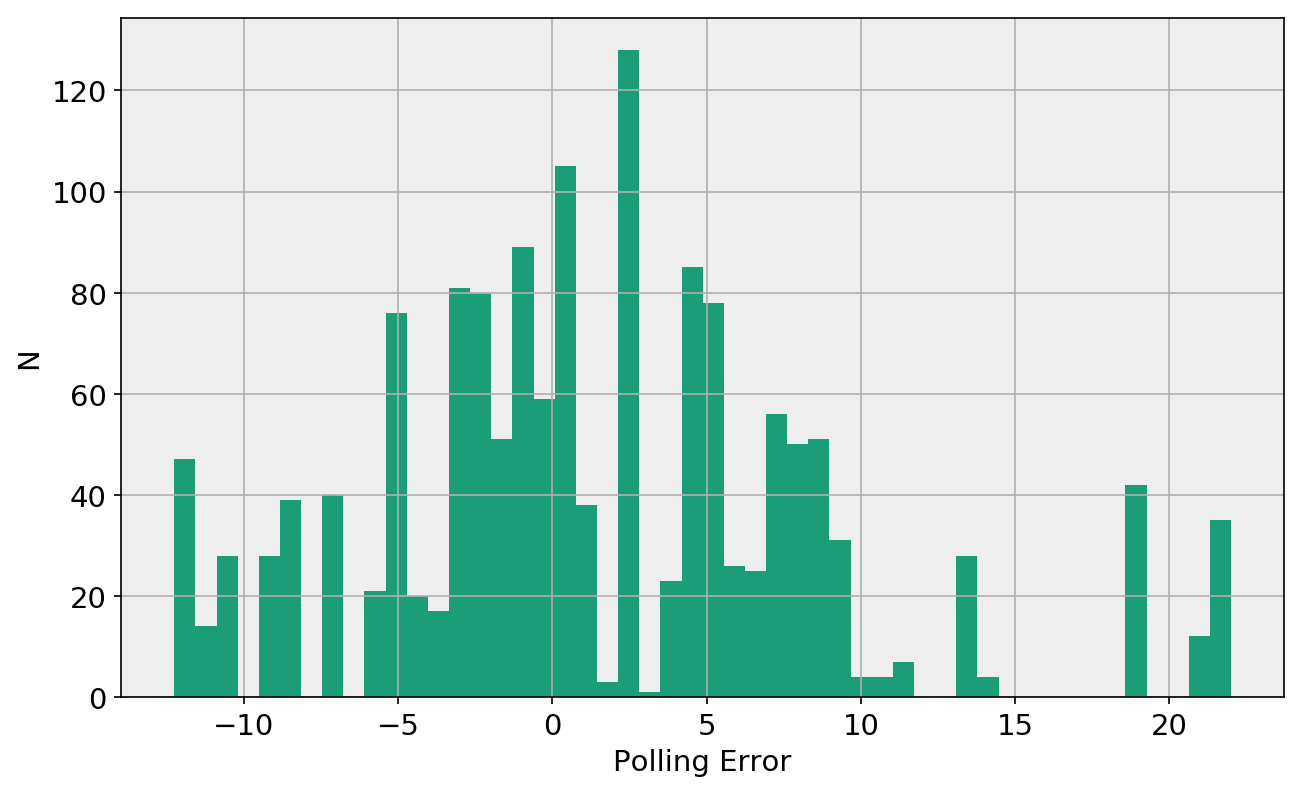

In [12]:
errors.error.hist(bins=50)
plt.xlabel("Polling Error")
plt.ylabel('N')

### Problem 6

Standard deviation of the polling errors. How much uncertainty is there in the typical RCP poll? <i>lets see!</i>

In [13]:

errors.error.std()


7.452242651758041

### Problem 7

Repeat this calculation for the data where `errors.forecast_length < 7` (i.e. the polls within a week of an election). How much more/less accurate are they? How about the data where `errors.forecast_length > 30`? 


In [ ]:

print (('When Forecast Length < 7: %0.2f') % errors[errors.forecast_length < 7].error.std())
print (('When Forecast Length > 30: %0.2f') % errors[errors.forecast_length > 30].error.std())

From the above output, we can clearly see that the polls which are taken with-in 7 days before elections are very accurate when compared with the polls which are taken a month before.

### Problem 8

**Bootstrap resampling** is a general purpose way to use empirical data like the `errors` DataFrame to estimate uncertainties. For example, consider the [Viriginia Governor Race](http://www.realclearpolitics.com/epolls/2013/governor/va/virginia_governor_cuccinelli_vs_mcauliffe-3033.html). If we wanted to estimate how likey it is that McAuliffe will win given the current RCP data, the approch would be:

1. Pick a large number N of experiments to run (say N=1000).
2. For each experiment, randomly select a value from `errors.error`. We are assuming that these numbers represent a reasonable error distribution for the current poll data.
3. Assume that the error on McAullife's current polling score is given by this number (and, by extension, the error on Cuccinelli's poll score is the opposite). Calculate who actually wins the election in this simulation.
4. Repeat N times, and calculate the percentage of simulations where either candidate wins.

Bootstrapping isn't foolproof: it makes the assumption that the previous Governor race errors are representative of the Virginia race, and it does a bad job at estimating very rare events (with only ~30 races in the errors DataFrame, it would be hard to accurately predict probabilities for 1-in-a-million scenarios). Nevertheless, it's a versatile technique.

Use bootstrap resampling to estimate how likely it is that each candidate could win the following races.

 * [Virginia Governor](http://www.realclearpolitics.com/epolls/2013/governor/va/virginia_governor_cuccinelli_vs_mcauliffe-3033.html)
 * [New Jersey Governor](http://www.realclearpolitics.com/epolls/2013/governor/nj/new_jersey_governor_christie_vs_buono-3411.html)
 
**Summarize your results in a paragraph. What conclusions do you draw from the bootstrap analysis, and what assumptions did you make in reaching this conclusion. What are some limitations of this analysis?**
 

In [73]:

def bootstrap_resample(c1,c2,errors,nsample = 1000):
    
    # Normalize votes to 100
    tot = c1 + c2
    c1 = (100*c1)/tot
    c2 = (100*c2)/tot
    
    indices = np.random.randint(0, errors.shape[0], nsample)
    error_value = errors.error.iloc[indices].values
    
    c1_actual = c1 - error_value
    c2_actual = c2 + error_value
    
    p1 = (c1_actual > c2_actual).mean()
    p2 = 1-p1
    return p1,p2


Cuccinelli, McAuliffe = 45.5, 48.0
nsample = 10000
pc, pm = bootstrap_resample(Cuccinelli, McAuliffe, errors, nsample)


print ("Virginia Race")
print ("-------------------------")
print ("P(Cuccinelli wins)  = %0.2f" % pm)
print ("P(McAuliffe wins) = %0.2f" % pc)

Buono, Christie = 38.1, 60.4
pb, pc = bootstrap_resample(Buono, Christie, errors, nsample)

print ('\n')
print ("New Jersy Race")
print ("-------------------------")
print ("P(Buono wins) = %0.2f" % pb)
print ("P(Christie wins)    = %0.2f" % pc)


Virginia Race
-------------------------
P(Cuccinelli wins)  = 0.64
P(McAuliffe wins) = 0.36


New Jersy Race
-------------------------
P(Buono wins) = 0.04
P(Christie wins)    = 0.96


Based on the above bootstrap model, we can see that Cuccinelli has 64% chance of winning the Virginia Race and Christie has 96% chance of winning the New Jersy Race!

---
*css tweaks in this cell*
<style>
div.text_cell_render {
    line-height: 150%;
    font-size: 110%;
    width: 800px;
    margin-left:50px;
    margin-right:auto;
    }
</style>